In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime


In [23]:
class Investment:
    
    def __init__(self, ticker, amount=1000, start="2006-01-01", end="2020-01-01",drip=True):
        
        self.ticker=ticker
        self.start=start
        self.end=end
        self.drip=drip
        self.initial_investment=amount
               
        
        def download_data():
            #use download to get non-adjusted Close price data
            stock_hist = yf.download(self.ticker,interval="1mo",start=self.start, end=self.end)[['Close']].copy()
            
            #use Ticker to get dividend and split data
            div_split_hist  = yf.Ticker(self.ticker).history(interval="1mo",start=self.start, end=self.end)[['Dividends','Stock Splits']].copy()
            
            stock_data = pd.concat([stock_hist, div_split_hist],axis=1)
            stock_data['Close'].interpolate(method='time',inplace=True)
            return stock_data
        
        def calculate_tables():  #should be able to clean this up a bit. can it be done within a dataframe?
            
            def split_multiplier(split):
                if split:
                    multiplier=1/split
                else:
                    multiplier=1
                return multiplier
            
            prices    = self.investment_data['Close'].values.tolist()
            dividends = self.investment_data['Dividends'].values.tolist()
            splits    = self.investment_data['Stock Splits'].values.tolist()
            
            #need to add in place substitute of 1 if split = 0
            
            
            #data      = list(zip(prices,dividends))
            initial_investment = amount
            
            #initialize investment state
            balance = [initial_investment]
            shares  = [balance[0]/prices[0]]
            cash    = [0]
            
            #create an iterable and increment before entering the "for" loop
            prices_iter = iter(prices.copy())
            buyprice    = next(prices_iter)  
    
            for month,price in enumerate(prices_iter,start=1):
                total_dividend = dividends[month]*shares[month-1]
                split = splits[month-1]
                if drip:
                    newshares = total_dividend/price
                    cash.append(0)
                else:
                    newshares = 0
                    cash.append(cash[month-1]+total_dividend)  
                shares.append((shares[month-1]+newshares))#*split_multiplier(split))
                balance.append(shares[month]*price+cash[month])
                
            #these variables could be combined into a dictionary
            self.investment_data['cash'],self.investment_data['shares'],self.investment_data['balance'] = [cash,shares,balance]
            
        def create_summary_table():
            gain = self.investment_data.tail(1)['balance'].values[0]/self.initial_investment
            
            date_time_start     = datetime.datetime.strptime(self.start, '%Y-%m-%d')
            date_time_end       = datetime.datetime.strptime(self.end, '%Y-%m-%d')
            investment_duration = (date_time_end-date_time_start).days/365
            
            annualized_return = gain**(1/investment_duration)-1
            
            self.summary = pd.DataFrame({"symbol":[self.ticker],"start date":[self.start],"end date":[self.end],
                                       "gain":[gain],"annualized return":[annualized_return]},
                                       columns=['symbol','start date','end date','gain','annualized return'])
                                
        
        
            
        self.investment_data=download_data()
        calculate_tables()
        create_summary_table()
        

In [31]:
t=Investment("aapl",start="1996-12-01", end="2019-08-01",drip=True)

[*********************100%***********************]  1 of 1 completed


In [32]:
t.investment_data

,Close,Dividends,Stock Splits,cash,shares,balance
Date,,,,,,
1996-12-01,0.745536,0.00,0.0,0,1341.317335,1000.000000
1997-01-01,0.593750,0.00,0.0,0,1341.317335,796.407167
1997-02-01,0.580357,0.00,0.0,0,1341.317335,778.443085
1997-03-01,0.651786,0.00,0.0,0,1341.317335,874.251500
1997-04-01,0.607143,0.00,0.0,0,1341.317335,814.371250
...,...,...,...,...,...,...
2019-05-01,175.070007,0.00,0.0,0,1521.192929,266315.257240
2019-05-10,181.703876,0.77,0.0,0,1527.639234,277577.969361
2019-06-01,197.919998,0.00,0.0,0,1527.639234,302350.354367


In [33]:
t.summary

,symbol,start date,end date,gain,annualized return
0,aapl,1996-12-01,2019-08-01,318.879422,0.289412


In [34]:
t.investment_data[t.investment_data['Dividends']>0]

,Close,Dividends,Stock Splits,cash,shares,balance
Date,,,,,,
2012-08-09,95.102859,0.37857,0.0,0,1346.656633,128070.895199
2012-11-07,82.093999,0.37857,0.0,0,1352.866633,111062.231675
2013-02-07,63.095716,0.37857,0.0,0,1360.983741,85872.243153
2013-05-09,62.285856,0.43571,0.0,0,1370.504269,85363.031132
2013-08-08,69.265116,0.43571,0.0,0,1379.125382,95525.279993
2013-11-06,79.556426,0.43571,0.0,0,1386.678496,110319.184778
2014-02-06,75.444996,0.43571,0.0,0,1394.686843,105222.143860
2014-05-08,90.993412,0.47000,0.0,0,1401.890692,127562.817156
2014-08-07,102.161290,0.47000,0.0,0,1408.340186,143877.850597


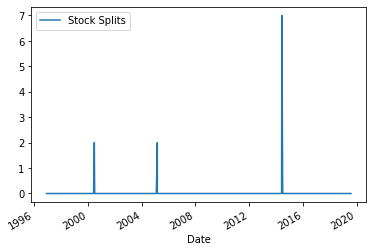

In [35]:
t.investment_data[['Stock Splits']].plot()

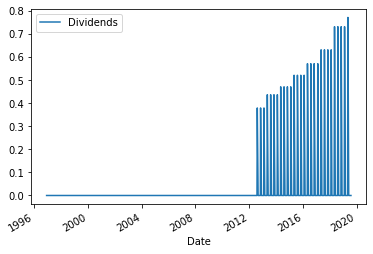

In [39]:
t.investment_data[['Dividends']].plot()

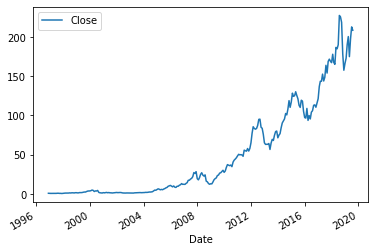

In [37]:
t.investment_data[['Close']].plot()